# New stuff Sep 2025

In [ ]:
pip install fastf1 kagglehub folium

In [ ]:
import os
import re
import math
import logging
import warnings
import unicodedata

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

import fastf1 as ff1
import kagglehub
import folium

In [ ]:
## just logs

logging.getLogger("fastf1").setLevel(logging.ERROR)
warnings.simplefilter(action='ignore', category=FutureWarning)
cache_dir = "/content/CacheFormulaOne"
os.makedirs(cache_dir, exist_ok=True)
ff1.Cache.enable_cache(cache_dir)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
CIRCUITS_GEO_PATH = "/content/drive/Shareddrives/Formula1/code/circuits_geo.csv"
WEATHER_PATH      = "/content/drive/Shareddrives/Formula1/code/meteorat_2.csv"
path = kagglehub.dataset_download("rohanrao/formula-1-world-championship-1950-2020")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'formula-1-world-championship-1950-2020' dataset.
Path to dataset files: /kaggle/input/formula-1-world-championship-1950-2020


In [ ]:
races        = pd.read_csv(os.path.join(path, 'races.csv'))
results      = pd.read_csv(os.path.join(path, 'results.csv'))
drivers      = pd.read_csv(os.path.join(path, 'drivers.csv'))
constructors = pd.read_csv(os.path.join(path, 'constructors.csv'))
lap_times    = pd.read_csv(os.path.join(path, 'lap_times.csv'))
pit_stops    = pd.read_csv(os.path.join(path, 'pit_stops.csv'))
qualifying   = pd.read_csv(os.path.join(path, 'qualifying.csv'))
seasons      = pd.read_csv(os.path.join(path, 'seasons.csv'))
status       = pd.read_csv(os.path.join(path, 'status.csv'))

In [ ]:
sprint_path = os.path.join(path, 'sprint_results.csv')
sprint_results = pd.read_csv(sprint_path) if os.path.exists(sprint_path) else pd.DataFrame()

In [ ]:
if os.path.exists(CIRCUITS_GEO_PATH):
    circuits_geo = pd.read_csv(CIRCUITS_GEO_PATH)
else:
    circuits_geo = pd.DataFrame()

if os.path.exists(WEATHER_PATH):
    weather = pd.read_csv(WEATHER_PATH)
    # just to make sure the columns exist
else:
    weather = pd.DataFrame(columns=['GP','Date','Avg_Temperature','Humidity','Precipitation'])

In [ ]:
## HELPERS
def normalize_name(name: str) -> str:
    """Normalize diacritics in names (Pérez -> Perez) for robust FastF1 code lookups."""
    if pd.isna(name):
        return ""
    return ''.join(c for c in unicodedata.normalize('NFKD', name) if unicodedata.category(c) != 'Mn')

def convert_time_to_seconds(time_str):
    """
    Convert strings like '+1:05.950' or '+0.232' to seconds (float).
    Accepts plain 'm:ss.sss' or 's.sss' too. Returns 0.0 on parse failure/NaN.
    """
    if pd.isna(time_str):
        return 0.0
    s = str(time_str).replace('+', '').strip()
    if ':' in s:
        m = re.match(r"(\d+):(\d+\.\d+)", s)
        if m:
            minutes, seconds = int(m.group(1)), float(m.group(2))
            return minutes * 60 + seconds
    else:
        try:
            return float(s)
        except ValueError:
            return 0.0
    return 0.0

def convert_seconds_to_time_str(seconds):
    """Format float seconds to 'm:ss.sss' (or 'N/A' if invalid)."""
    if pd.isna(seconds) or seconds < 0:
        return 'N/A'
    minutes = int(seconds // 60)
    leftover = seconds % 60
    return f"{minutes}:{leftover:05.3f}"

def plot_driver_telemetry(driver_name, year, gp_name, identifier="R", best_race=None):
    """
    Plot FastF1 lap trace colored by speed for the driver in a given session (Race by default).
    best_race: dict with 'fastest_lap_number' to lock to a specific lap; otherwise pick fastest lap.
    """
    try:
        session = ff1.get_session(int(year), gp_name, identifier)
        session.load()
    except Exception as e:
        print(f"FastF1 session load failed for {year} {gp_name}: {e}")
        return

    surname = str(driver_name).split()[-1]
    driver_code = normalize_name(surname)[:3].upper()

    try:
        laps = session.laps.pick_driver(driver_code)
        if best_race and 'fastest_lap_number' in best_race and pd.notna(best_race['fastest_lap_number']):
            sel = laps[laps['LapNumber'] == int(best_race['fastest_lap_number'])]
            if sel.empty:
                print(f"No telemetry for lap {best_race['fastest_lap_number']} → using fastest lap.")
                selected_lap = laps.pick_fastest()
            else:
                selected_lap = sel.iloc[0]
        else:
            selected_lap = laps.pick_fastest()
        telemetry_data = selected_lap.get_telemetry()
    except Exception as e:
        print(f"No telemetry data available: {e}")
        return

    x = telemetry_data['X'].to_numpy()
    y = telemetry_data['Y'].to_numpy()
    speed = telemetry_data['Speed'].to_numpy()

    fig, ax = plt.subplots(figsize=(12, 6))
    fig.suptitle(f'{gp_name} {year} - {surname} Lap {int(selected_lap["LapNumber"])} - Speed', size=22, y=0.98)
    ax.axis('off')

    pts = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)

    ax.plot(x, y, color='black', linestyle='-', linewidth=14, zorder=0)
    cmap = mpl.cm.plasma
    norm = plt.Normalize(speed.min(), speed.max())
    lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='-', linewidth=4)
    lc.set_array(speed)
    ax.add_collection(lc)

    cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
    mpl.colorbar.ColorbarBase(cbaxes, norm=norm, cmap=cmap, orientation="horizontal")
    plt.show()

In [ ]:
winners_since_2018 = (
    results.loc[results['positionOrder'] == 1]
    .merge(races[['raceId','year','name','date']], on='raceId', how='left')
    .merge(drivers[['driverId','forename','surname']], on='driverId', how='left')
)
winners_since_2018 = winners_since_2018[winners_since_2018['year'] >= 2018].copy()
winners_since_2018['Driver'] = winners_since_2018['forename'] + ' ' + winners_since_2018['surname']

available_winner_drivers = (
    winners_since_2018[['driverId','Driver']]
    .drop_duplicates()
    .reset_index(drop=True)
)

print("Drivers who have won at least one race since 2018:\n")
for _, row in available_winner_drivers.iterrows():
    d_id = row['driverId']; name = row['Driver']
    wins = winners_since_2018.loc[winners_since_2018['driverId'] == d_id, ['year', 'name']]
    wins_str = ", ".join(f"{int(yr)} {gp}" for yr, gp in wins.values)
    print(f"{name} (ID {d_id})")

# Convenience dict: name -> id (lowercased)
NAME_TO_ID = {n.lower(): i for i, n in available_winner_drivers.itertuples(index=False)}
def driver_id_by_name(name_like: str):
    key = normalize_name(name_like).lower().strip()
    # try exact match first, then fallback by last token
    if key in NAME_TO_ID:
        return NAME_TO_ID[key]
    last = key.split()[-1]
    for n, i in NAME_TO_ID.items():
        if last and last in normalize_name(n).lower():
            return i
    raise KeyError(f"Driver '{name_like}' not found among winners since 2018.")

Drivers who have won at least one race since 2018:

Sebastian Vettel (ID 20)
Daniel Ricciardo (ID 817)
Lewis Hamilton (ID 1)
Max Verstappen (ID 830)
Kimi Räikkönen (ID 8)
Valtteri Bottas (ID 822)
Charles Leclerc (ID 844)
Pierre Gasly (ID 842)
Sergio Pérez (ID 815)
Esteban Ocon (ID 839)
Carlos Sainz (ID 832)
George Russell (ID 847)
Lando Norris (ID 846)
Oscar Piastri (ID 857)


In [ ]:
def top_races_for_driver(driverId, n_top=3, min_year=2018, wins_only=False, plot_first=True):
    """
    Return & print the top N races (by custom score) for a driver since `min_year`.
    Set wins_only=True to limit to wins. If plot_first=True, shows FastF1 telemetry for #1 (2018+).
    """
    # local copies (avoid mutating globals)
    _res = results.copy()
    _rac = races[['raceId','name','year','date']].copy()
    _drv = drivers[['driverId','forename','surname']].copy()
    _sts = status[['statusId','status']].copy()
    _wth = weather.copy()

    # merge status & compute status_weight (finished=+1, DNF-like statuses=0)
    dnf_status_ids = {
        1, 2, 11, 12, 13, 14, 15, 16, 17, 18, 19, 45, 50, 128, 53, 55, 58, 88,
        111,112,113,114,115,116,117,118,119,120,122,123,124,125,127,133,134
    }
    if 'statusId' in _res.columns and 'statusId' in _sts.columns:
        _res = _res.merge(_sts, on='statusId', how='left', suffixes=('', '_status'))
        _res['status_weight'] = _res['statusId'].apply(
            lambda sid: 0 if pd.isna(sid) or sid in dnf_status_ids else 1
        )
    else:
        _res['status_weight'] = 0

    dr = _res[_res['driverId'] == driverId].copy()
    dr = dr.merge(_rac, on='raceId', how='left').merge(_drv, on='driverId', how='left')
    dr = dr[dr['year'] >= min_year]

    if wins_only:
        dr = dr[dr['positionOrder'] == 1]

    if dr.empty:
        print(f"No races found for driverId {driverId} in {min_year}+ (wins_only={wins_only}).")
        return pd.DataFrame()

    # weather merge (if provided)
    if not _wth.empty and {'GP','Date'}.issubset(_wth.columns):
        dr = dr.merge(_wth, left_on=['name','date'], right_on=['GP','Date'], how='left')
    else:
        # ensure columns exist for code below
        for col in ['Avg_Temperature','Humidity','Precipitation']:
            if col not in dr.columns:
                dr[col] = np.nan

    # P2 margin
    p2 = _res[_res['positionOrder'] == 2][['raceId','time']].rename(columns={'time':'p2_gap'})
    dr = dr.merge(p2, on='raceId', how='left')
    dr['margin_of_victory'] = dr['p2_gap'].apply(convert_time_to_seconds).fillna(0.0)

    # features
    dr['gained_positions']   = (dr['grid'] - dr['positionOrder']).fillna(0)
    dr['fastest_lap_time_s'] = dr['fastestLapTime'].apply(convert_time_to_seconds).fillna(0.0)
    dr['fastest_lap_speed']  = pd.to_numeric(dr['fastestLapSpeed'], errors='coerce').fillna(0.0)
    dr['fastest_lap_number'] = dr['fastestLap']

    # wetness heuristic
    def wet_bonus_fn(p):
        if pd.isna(p): p = 0
        if 5 <= p < 10:   return 10
        if 10 <= p < 20:  return 30
        if 20 <= p < 50:  return 80
        if p >= 50:       return 100
        return 0
    dr['wet_bonus'] = dr['Precipitation'].apply(wet_bonus_fn)

    # scoring (fast laps help via negative weight on time)
    W = {
        'gained_positions'   : 4.0,
        'margin_of_victory'  : 1.0,
        'fastest_lap_time_s' : -1.0,   # lower is better
        'fastest_lap_speed'  : 1.0,
        'status_weight'      : 1.0,
        'wet_bonus'          : 1.0
    }

    dr['score'] = (
        dr['gained_positions']   * W['gained_positions'] +
        dr['margin_of_victory']  * W['margin_of_victory'] +
        dr['fastest_lap_time_s'] * W['fastest_lap_time_s'] +
        dr['fastest_lap_speed']  * W['fastest_lap_speed'] +
        dr['status_weight'].fillna(0) * W['status_weight'] +
        dr['wet_bonus']          * W['wet_bonus']
    )

    topN = dr.sort_values('score', ascending=False).head(n_top).reset_index(drop=True)

    driver_name = (topN['forename'].iloc[0] + ' ' + topN['surname'].iloc[0]) if not topN.empty else f"ID {driverId}"
    print(f"\nTop {len(topN)} races for {driver_name} since {min_year} (wins_only={wins_only}):")
    for i, row in topN.iterrows():
        print(f"\n#{i+1}: {int(row['year'])} {row['name']}")
        print(f"   Score: {row['score']:.2f} | Start {int(row['grid'])} → Finish {int(row['positionOrder'])} "
              f"(+{int(row['gained_positions'])})")
        print(f"   MoV to P2: {row['margin_of_victory']:.3f}s | Fastest lap: "
              f"{convert_seconds_to_time_str(row['fastest_lap_time_s'])} "
              f"({row['fastest_lap_speed']} km/h, lap {row['fastest_lap_number']})")
        print(f"   Weather: T={row.get('Avg_Temperature', 'N/A')}°C, "
              f"P={row.get('Precipitation','N/A')}mm | Wet bonus={row['wet_bonus']}")

    if plot_first and not topN.empty and int(topN.loc[0,'year']) >= 2018:
        dn = f"{topN.loc[0,'forename']} {topN.loc[0,'surname']}"
        best_info = {}
        if pd.notna(topN.loc[0,'fastest_lap_number']):
            best_info['fastest_lap_number'] = int(topN.loc[0,'fastest_lap_number'])
        plot_driver_telemetry(dn, int(topN.loc[0,'year']), topN.loc[0,'name'],
                              identifier="R", best_race=best_info if best_info else None)
    elif plot_first and not topN.empty:
        print("Telemetry only available for 2018+.")

    return topN



Top 3 races for Max Verstappen since 2018 (wins_only=False):

#1: 2024 São Paulo Grand Prix
   Score: 275.77 | Start 17 → Finish 1 (+16)
   MoV to P2: 19.477s | Fastest lap: 1:20.472 (192.767 km/h, lap 67)
   Weather: T=20.5°C, P=43.9mm | Wet bonus=80

#2: 2021 Russian Grand Prix
   Score: 240.83 | Start 20 → Finish 2 (+18)
   MoV to P2: 53.271s | Fastest lap: 1:38.396 (213.959 km/h, lap 28)
   Weather: T=14.7°C, P=3.6mm | Wet bonus=0

#3: 2018 German Grand Prix
   Score: 225.77 | Start 4 → Finish 4 (+0)
   MoV to P2: 4.535s | Fastest lap: 1:15.852 (217.085 km/h, lap 66)
   Weather: T=20.2°C, P=39.2mm | Wet bonus=80


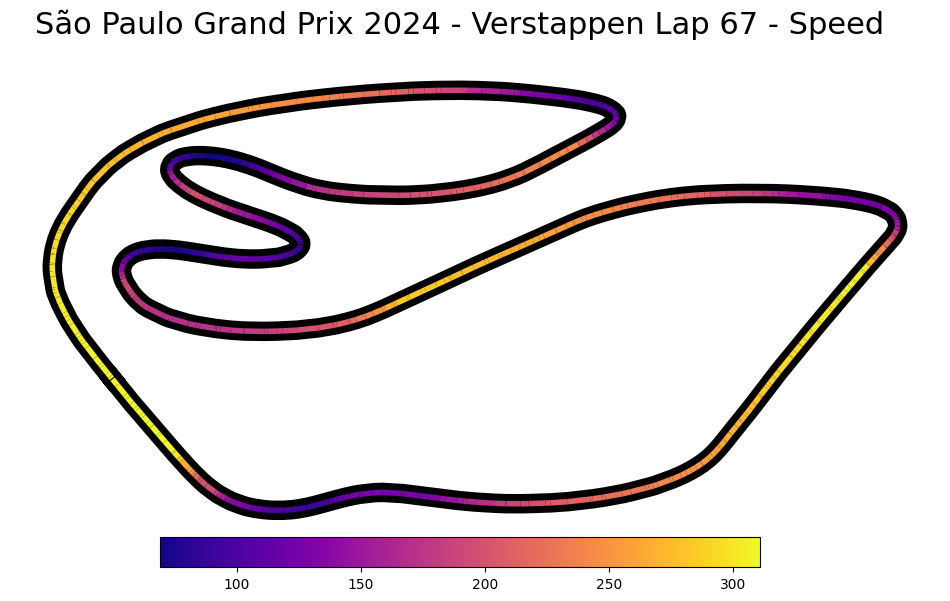

In [ ]:
try:
    driver_id = driver_id_by_name("Max Verstappen")
    top3 = top_races_for_driver(driver_id, n_top=3, min_year=2018, wins_only=False, plot_first=True)
except KeyError as e:
    print(e)

In [ ]:
def add_position_gaps(df_results: pd.DataFrame) -> pd.DataFrame:
    """
    For each race, compute:
      - gap_to_winner_s: time behind the winner in seconds (0 for winner).
      - gap_to_next_s:   time gap to the car behind (P[k+1] - P[k]); for winner it equals MoV to P2.
                         NaN for the last classified car in a race.

    Uses '+…' gap strings in 'time' if present; otherwise falls back to numeric 'milliseconds' vs winner.
    """
    use_cols = ['raceId', 'driverId', 'positionOrder', 'time', 'milliseconds']
    g = df_results[use_cols].copy()

    # make sure we can sort and do arithmetic
    g['positionOrder']    = pd.to_numeric(g['positionOrder'], errors='coerce')
    g['milliseconds_num'] = pd.to_numeric(g['milliseconds'], errors='coerce')  # turns "\N" into NaN

    def compute_for_race(gr):
        gr = gr.sort_values('positionOrder').copy()

        # winner baseline (numeric ms)
        win_ms_series = gr.loc[gr['positionOrder'] == 1, 'milliseconds_num']
        win_ms = win_ms_series.iloc[0] if not win_ms_series.empty else np.nan

        def gap_to_win(row):
            t = row['time']
            # prefer explicit +gap strings (e.g., +0.523, +1:05.950)
            if isinstance(t, str) and t.strip().startswith('+'):
                sec = convert_time_to_seconds(t)
                if sec is not None:
                    return sec
            # fallback: milliseconds difference to winner
            if pd.notna(row['milliseconds_num']) and pd.notna(win_ms):
                return max(0.0, (row['milliseconds_num'] - win_ms) / 1000.0)
            # default: winner gets 0, others unknown
            return 0.0 if row['positionOrder'] == 1 else np.nan

        gr['gap_to_winner_s'] = gr.apply(gap_to_win, axis=1)

        # gap to car behind = Δ(gap_to_winner_s) to the next finisher
        gr['gap_to_next_s'] = gr['gap_to_winner_s'].shift(-1) - gr['gap_to_winner_s']
        # last classified car has no one behind
        if len(gr) > 0:
            gr.iloc[-1, gr.columns.get_loc('gap_to_next_s')] = np.nan

        return gr[['raceId', 'driverId', 'gap_to_winner_s', 'gap_to_next_s']]

    out = g.groupby('raceId', group_keys=False).apply(compute_for_race)
    return df_results.merge(out, on=['raceId', 'driverId'], how='left')

def top_races_for_driver(driverId, n_top=3, min_year=2018, wins_only=False, plot_first=True):
    """
    Top N races by custom score since `min_year`.

    Gap logic:
      - Winner: uses gap_to_next_s (MoV to P2) as a positive.
      - Non-winner: penalize gap_to_winner_s (bigger is worse) and reward gap_to_next_s (bigger is better).
    """
    # local copies
    _res = results.copy()
    _rac = races[['raceId','name','year','date']].copy()
    _drv = drivers[['driverId','forename','surname']].copy()
    _sts = status[['statusId','status']].copy()
    _wth = weather.copy()

    # status weight
    dnf_status_ids = {
        1, 2, 11, 12, 13, 14, 15, 16, 17, 18, 19, 45, 50, 128, 53, 55, 58, 88,
        111,112,113,114,115,116,117,118,119,120,122,123,124,125,127,133,134
    }
    if 'statusId' in _res.columns and 'statusId' in _sts.columns:
        _res = _res.merge(_sts, on='statusId', how='left', suffixes=('', '_status'))
        _res['status_weight'] = _res['statusId'].apply(
            lambda sid: 0 if pd.isna(sid) or sid in dnf_status_ids else 1
        )
    else:
        _res['status_weight'] = 0

    # add position-aware gaps (robust to string milliseconds)
    _res = add_position_gaps(_res)

    # select driver + year filter
    dr = _res[_res['driverId'] == driverId].copy()
    dr = dr.merge(_rac, on='raceId', how='left').merge(_drv, on='driverId', how='left')
    dr = dr[pd.to_numeric(dr['year'], errors='coerce') >= min_year]

    if wins_only:
        dr = dr[dr['positionOrder'] == 1]

    if dr.empty:
        print(f"No races found for driverId {driverId} in {min_year}+ (wins_only={wins_only}).")
        return pd.DataFrame()

    # weather (optional)
    if not _wth.empty and {'GP','Date'}.issubset(_wth.columns):
        dr = dr.merge(_wth, left_on=['name','date'], right_on=['GP','Date'], how='left')
    for col in ['Avg_Temperature','Humidity','Precipitation']:
        if col not in dr.columns:
            dr[col] = np.nan

    # features
    dr['gained_positions']   = (pd.to_numeric(dr['grid'], errors='coerce') - pd.to_numeric(dr['positionOrder'], errors='coerce')).fillna(0)
    dr['fastest_lap_time_s'] = dr['fastestLapTime'].apply(convert_time_to_seconds).fillna(0.0)
    dr['fastest_lap_speed']  = pd.to_numeric(dr['fastestLapSpeed'], errors='coerce').fillna(0.0)
    dr['fastest_lap_number'] = dr['fastestLap']

    # wetness heuristic
    def wet_bonus_fn(p):
        if pd.isna(p): p = 0
        if 5 <= p < 10:   return 10
        if 10 <= p < 20:  return 30
        if 20 <= p < 50:  return 80
        if p >= 50:       return 100
        return 0
    dr['wet_bonus'] = dr['Precipitation'].apply(wet_bonus_fn)

    # scoring
    W = {
        'gained_positions'   : 4.0,
        'gap_to_next_s'      : 1.2,   # security over the car behind
        'gap_to_winner_s'    : -2.0,  # distance to P1 is bad
        'fastest_lap_time_s' : -1.0,  # lower is better
        'fastest_lap_speed'  : 1.0,
        'status_weight'      : 1.0,
        'wet_bonus'          : 1.0
    }

    dr['gap_to_next_s']   = pd.to_numeric(dr['gap_to_next_s'], errors='coerce').fillna(0.0)
    dr['gap_to_winner_s'] = pd.to_numeric(dr['gap_to_winner_s'], errors='coerce').fillna(0.0)

    dr['score'] = (
        dr['gained_positions']   * W['gained_positions'] +
        dr['gap_to_next_s']      * W['gap_to_next_s'] +
        dr['gap_to_winner_s']    * W['gap_to_winner_s'] +
        dr['fastest_lap_time_s'] * W['fastest_lap_time_s'] +
        dr['fastest_lap_speed']  * W['fastest_lap_speed'] +
        dr['status_weight']      * W['status_weight'] +
        dr['wet_bonus']          * W['wet_bonus']
    )

    topN = dr.sort_values('score', ascending=False).head(n_top).reset_index(drop=True)

    # safe int printer
    def _i(x, default=0):
        try:
            return int(x)
        except Exception:
            return default

    driver_name = (topN['forename'].iloc[0] + ' ' + topN['surname'].iloc[0]) if not topN.empty else f"ID {driverId}"
    print(f"\nTop {len(topN)} races for {driver_name} since {min_year} (wins_only={wins_only}):")
    for i, row in topN.iterrows():
        pos = _i(row['positionOrder'], -1)
        print(f"\n#{i+1}: {_i(row['year'])} {row['name']} (P{pos})")
        if pos == 1:
            print(f"   MoV to P2: {row['gap_to_next_s']:.3f}s")
        else:
            print(f"   Gap to P1: {row['gap_to_winner_s']:.3f}s | Gap to car behind: {row['gap_to_next_s']:.3f}s")
        print(f"   Score: {row['score']:.2f} | Start {_i(row['grid'], -1)} → Finish {pos} "
              f"(+{_i(row['gained_positions'])})")
        print(f"   Fastest lap: {convert_seconds_to_time_str(row['fastest_lap_time_s'])} "
              f"({row['fastest_lap_speed']} km/h, lap {row['fastest_lap_number']})")
        print(f"   Weather: T={row.get('Avg_Temperature', 'N/A')}°C, "
              f"H={row.get('Humidity','N/A')}%, "
              f"P={row.get('Precipitation','N/A')}mm | Wet bonus={row['wet_bonus']}")


    if plot_first and not topN.empty:
        for i, row in topN.iterrows():
            year = int(row['year'])
            if year < 2018:
                print(f"Skipping telemetry for {year} {row['name']} (not available pre-2018).")
                continue

            driver_full = f"{row['forename']} {row['surname']}"
            lap_info = {}
            if pd.notna(row['fastest_lap_number']):
                try:
                    lap_info['fastest_lap_number'] = int(row['fastest_lap_number'])
                except Exception:
                    pass

            print(f"\nPlotting telemetry for #{i+1}: {year} {row['name']} (P{int(row['positionOrder'])})")
            plot_driver_telemetry(driver_full, year, row['name'],
                                  identifier="R", best_race=lap_info if lap_info else None)
    elif plot_first and not topN.empty:
        print("Telemetry only available for 2018+.")

    return topN

/tmp/ipython-input-1192141639.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = g.groupby('raceId', group_keys=False).apply(compute_for_race)



Top 3 races for Lewis Hamilton since 2018 (wins_only=False):

#1: 2018 German Grand Prix (P1)
   MoV to P2: 4.535s
   Score: 279.87 | Start 14 → Finish 1 (+13)
   Fastest lap: 1:15.545 (217.968 km/h, lap 66)
   Weather: T=20.2°C, H=nan%, P=39.2mm | Wet bonus=80

#2: 2022 Italian Grand Prix (P5)
   Gap to P1: 5.380s | Gap to car behind: 0.711s
   Score: 208.65 | Start 19 → Finish 5 (+14)
   Fastest lap: 1:24.434 (246.995 km/h, lap 43)
   Weather: T=21.7°C, H=nan%, P=0.0mm | Wet bonus=0

#3: 2021 Russian Grand Prix (P1)
   MoV to P2: 53.271s
   Score: 194.11 | Start 4 → Finish 1 (+3)
   Fastest lap: 1:37.575 (215.76 km/h, lap 43)
   Weather: T=14.7°C, H=nan%, P=3.6mm | Wet bonus=0

Plotting telemetry for #1: 2018 German Grand Prix (P1)


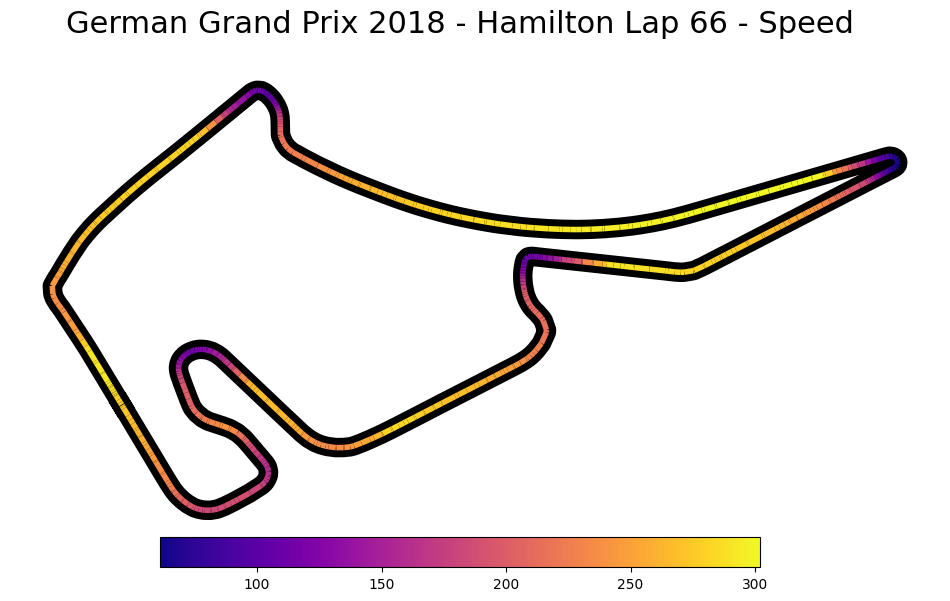


Plotting telemetry for #2: 2022 Italian Grand Prix (P5)


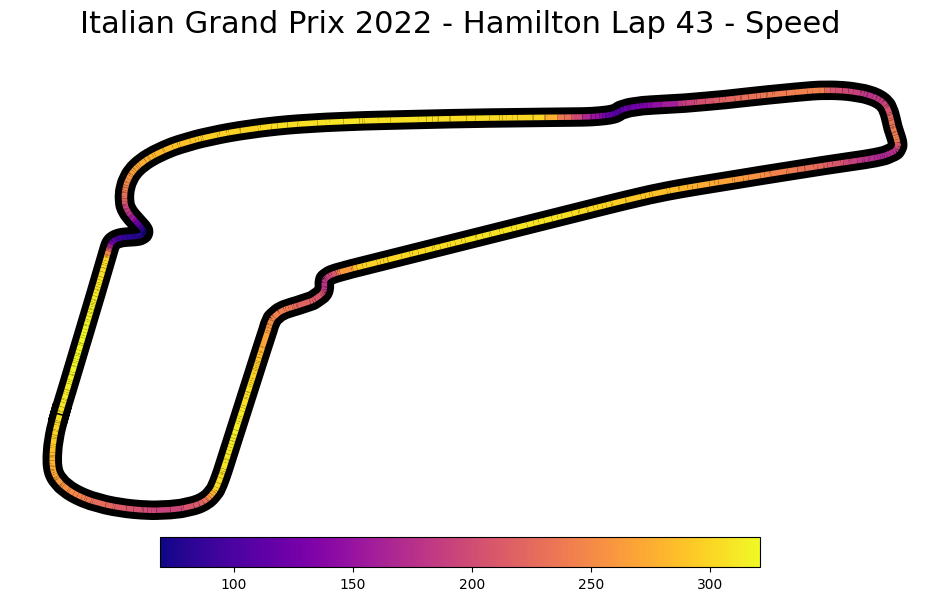


Plotting telemetry for #3: 2021 Russian Grand Prix (P1)


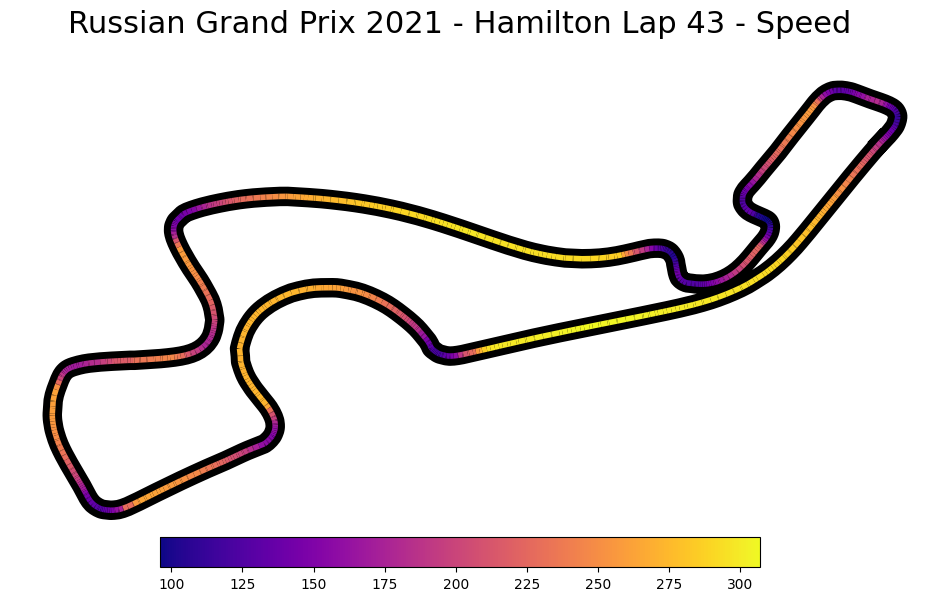

In [ ]:
top3 = top_races_for_driver(driverId=1, n_top=3, min_year=2018, wins_only=False, plot_first=True)